#### Jupyter Notebook to generate noisy images, segment, and evaluate error.


#### Imports

In [1]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
import matplotlib.pyplot as plt
from shutil import copy
from scipy.misc import imread, imsave

from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from AxonDeepSeg.testing.noise_simulation import *

%matplotlib inline

#### Function definitions

#### Path to change (put path to image to segment)

In [2]:
path_img = '/Users/rudinakaprata/Documents/Aldo/ads_feb/axondeepseg/AxonDeepSeg/data_test/image.png'

#### Set paths for AxonDeepSeg segmentation tools

In [3]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = 'default_TEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask > 200
gt_myelin = np.logical_and(mask >= 50, mask <= 200)

#### 1) Batch for simulation of gaussian blurring:

- For all noise values, generates noisy image, creates sub-folder, saves noisy image, launches AxonDeepSeg segmentation on noisy image, computes and saves prediction accuracy.

In [7]:
values = np.linspace(0,10,9)
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
pw_accuracy_array = np.empty(0)
img_array = []
pred_array = []

import tensorflow as tf
tf.reset_default_graph()

for sigma_values in values:
    
    # Generate and save noisy image
    img_noise = add_gaussian_blurring(img,sigma_values)
    file_name = 'image_' + str(int(sigma_values)) + '.png'
    directory_name = 'image_blur_' + str(int(sigma_values))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    imageio.imwrite(os.path.join(path_folder,directory_name,file_name),img_noise)
    img_array.append(img_noise[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy.png'),img_noise[100:400,100:400])
    
    # Segment noisy image with AxonDeepSeg
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,resampled_resolutions=0.01,verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_array.append(prediction[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy_pred.png'),prediction[100:400,100:400])
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    pw_accuracy = classification_accuracy(prediction,mask)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    pw_accuracy_array = np.append(pw_accuracy_array, [pw_accuracy], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin, 'pixelwise_accuracy': pw_accuracy}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()

IndexError: too many indices for array

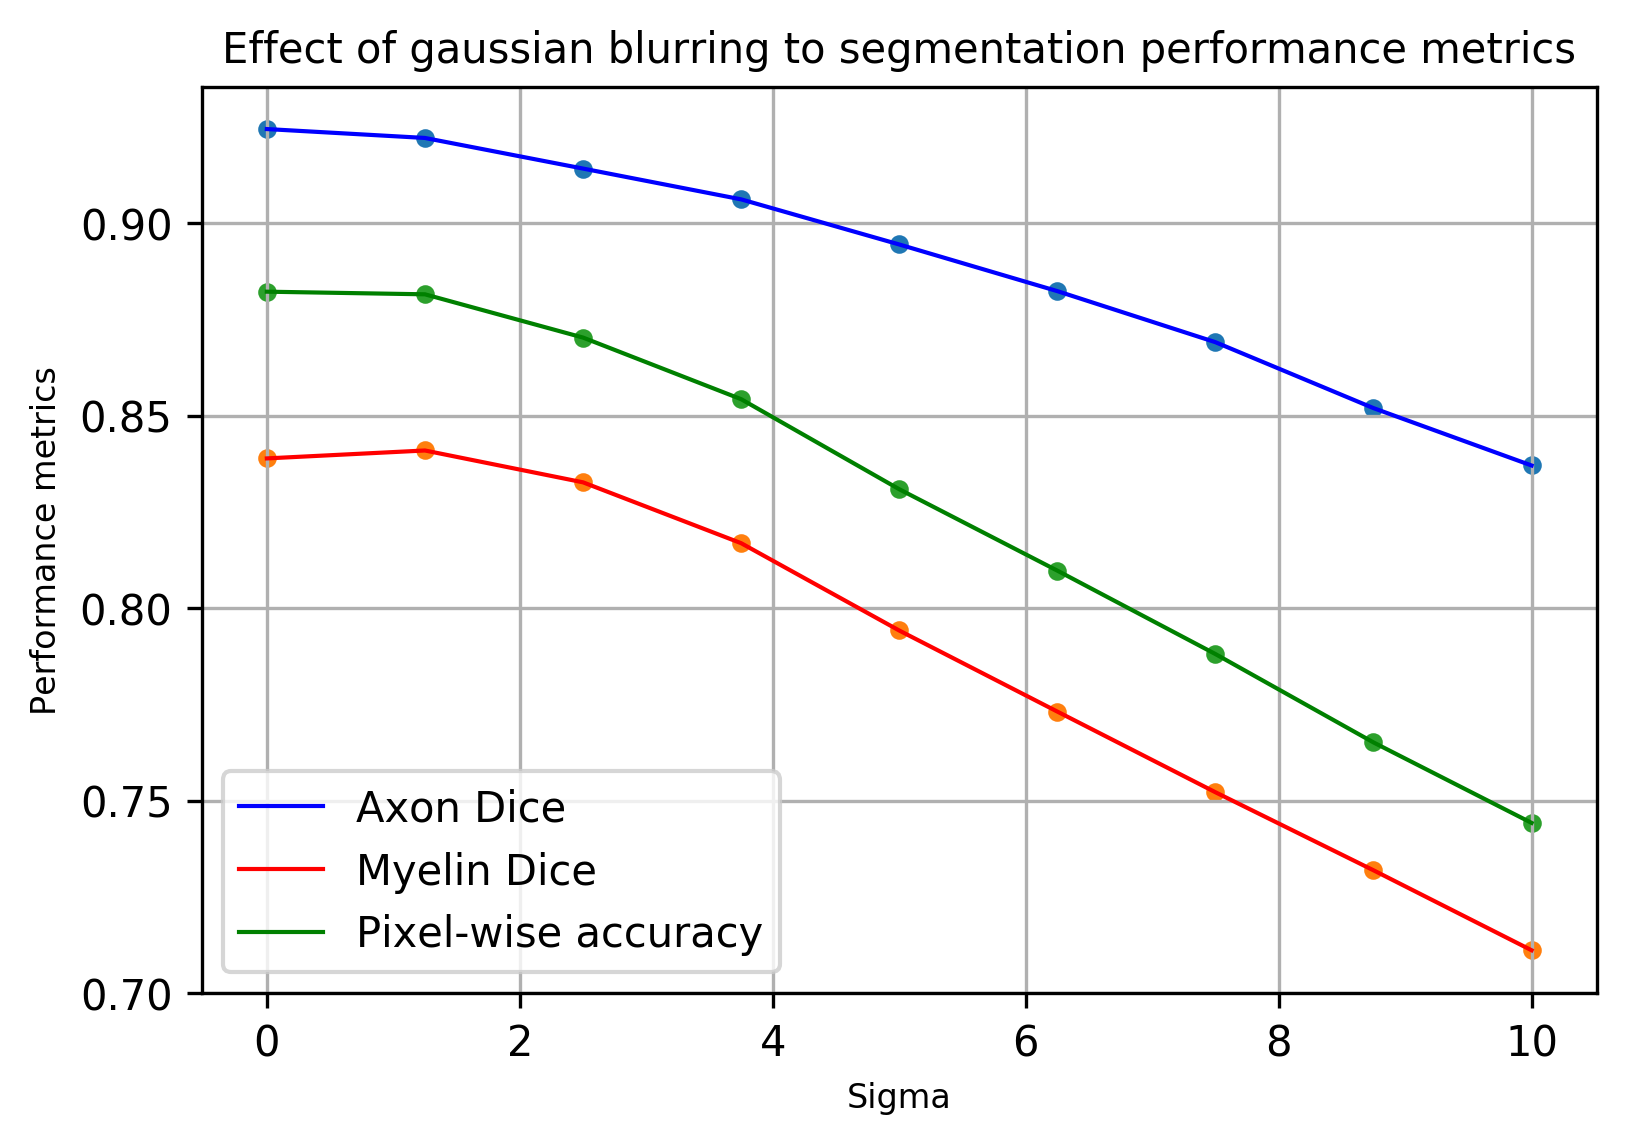

In [5]:
plt.figure(dpi=300)
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.hold(True) 
plt.plot(values, pw_accuracy_array, 'g', lw=1)
plt.scatter(values, pw_accuracy_array, s=12)

plt.xlabel('Sigma',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of gaussian blurring to segmentation performance metrics',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice','Pixel-wise accuracy'])
#plt.xlim(0, 0.3)
plt.grid(True)

Text(0.5,0.98,u'Sigma of gaussian blurring')

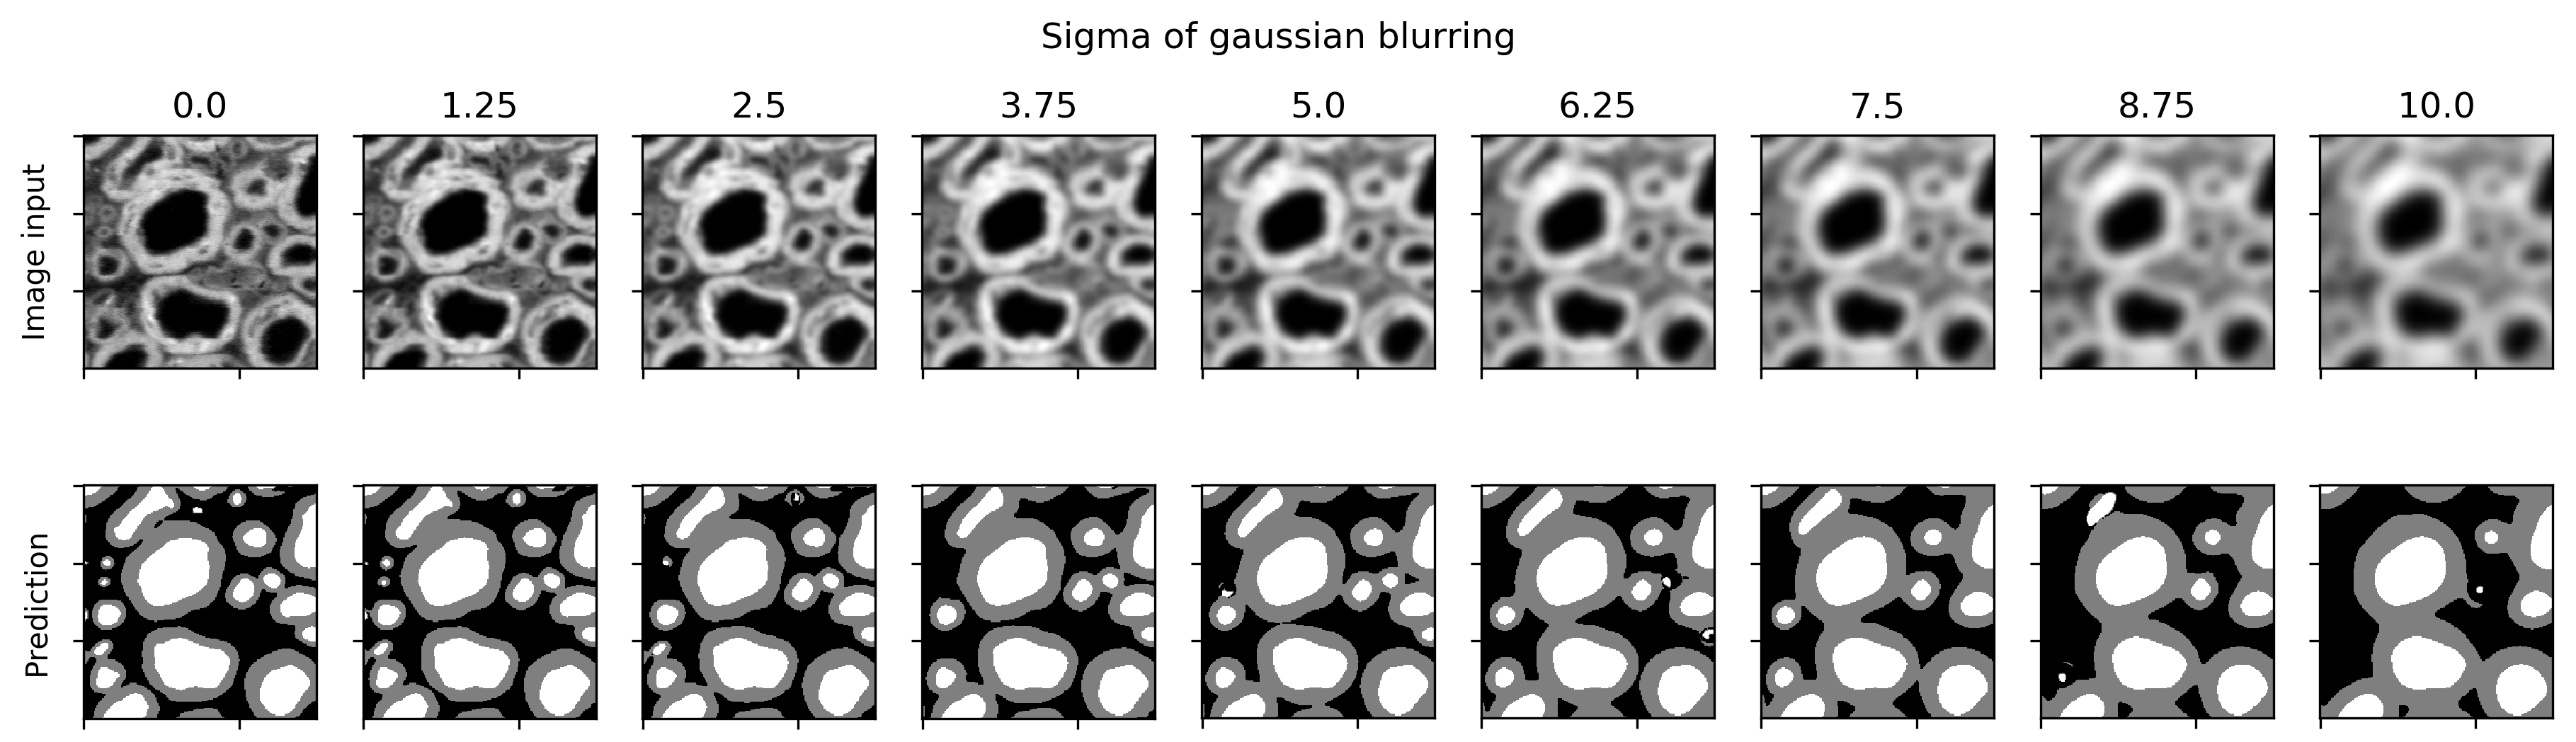

In [6]:
fig = plt.figure(figsize=(15,4),dpi=300)
items = np.arange(0,values.size)

for pos in items:

    plt.subplot(2,items.size,pos+1)
    plt.imshow(img_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.title('%s'%((values[pos])))
    
    if pos==0:
        plt.ylabel('Image input',fontsize=10)

    plt.subplot(2,items.size,(pos+1)+items.size)
    plt.imshow(pred_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([]) 
    
    if pos==0:
        plt.ylabel('Prediction',fontsize=10)
    
plt.suptitle("Sigma of gaussian blurring", fontsize=12)  


#### 2) Batch for simulation of gaussian additive noise:

- For all noise values, generates noisy image, creates sub-folder, saves noisy image, launches AxonDeepSeg segmentation on noisy image, computes and saves prediction accuracy.

In [41]:
values = np.linspace(0,30,9)
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
pw_accuracy_array = np.empty(0)
img_array = []
pred_array = []

for sigma_values in values:
    
    # Generate and save noisy image
    img_noise = add_additive_gaussian_noise(img,0,sigma_values)
    file_name = 'image_' + str(int(sigma_values)) + '.png'
    directory_name = 'image_add_' + str(int(sigma_values))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    imageio.imwrite(os.path.join(path_folder,directory_name,file_name),img_noise)
    img_array.append(img_noise[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy.png'),img_noise[100:400,100:400])
    
    # Segment noisy image with AxonDeepSeg
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_array.append(prediction[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy_pred.png'),prediction[100:400,100:400])
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    pw_accuracy = classification_accuracy(prediction,mask)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    pw_accuracy_array = np.append(pw_accuracy_array, [pw_accuracy], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin, 'pixelwise_accuracy': pw_accuracy}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()

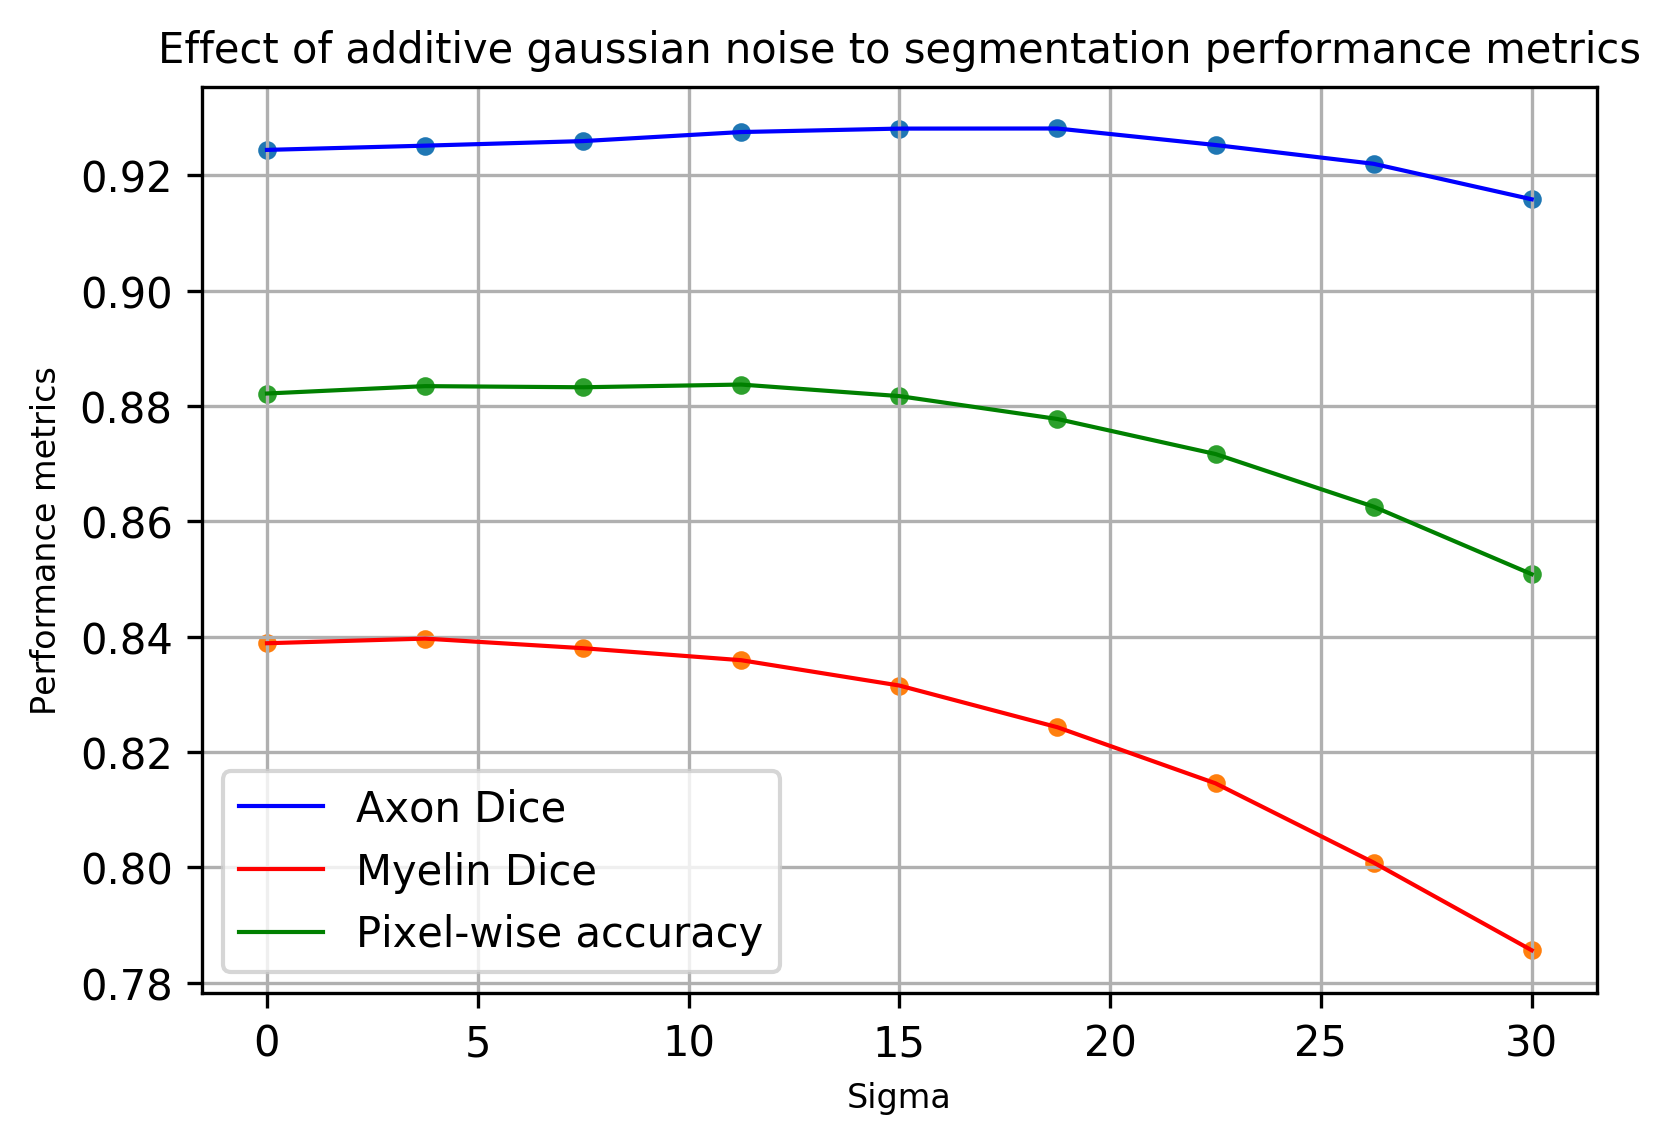

In [42]:
plt.figure(dpi=300)
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.hold(True) 
plt.plot(values, pw_accuracy_array, 'g', lw=1)
plt.scatter(values, pw_accuracy_array, s=12)

plt.xlabel('Sigma',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of additive gaussian noise to segmentation performance metrics',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice','Pixel-wise accuracy'])
#plt.xlim(0, 0.3)
plt.grid(True)

Text(0.5,0.98,u'Sigma of additive gaussian noise')

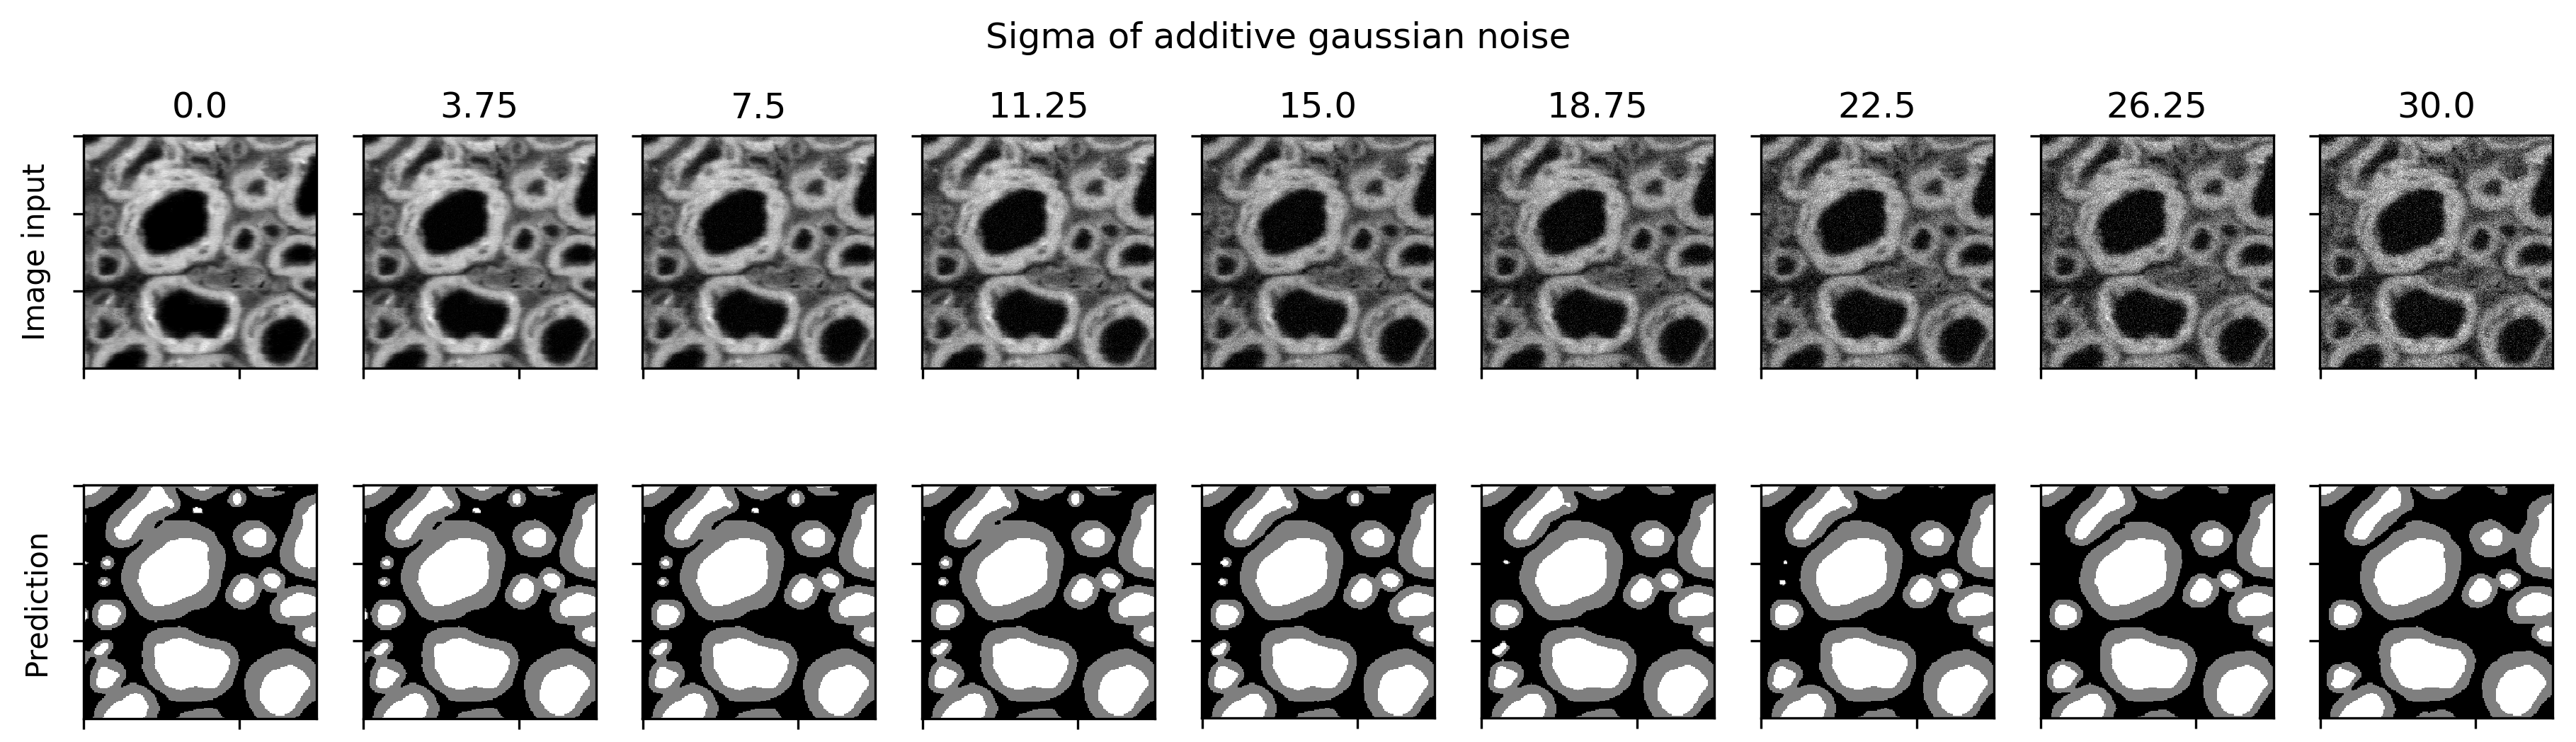

In [54]:
fig = plt.figure(figsize=(15,4),dpi=300)
items = np.arange(0,values.size)

for pos in items:

    plt.subplot(2,items.size,pos+1)
    plt.imshow(img_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.title('%s'%((values[pos])))
    
    if pos==0:
        plt.ylabel('Image input',fontsize=10)

    plt.subplot(2,items.size,(pos+1)+items.size)
    plt.imshow(pred_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([]) 
    
    if pos==0:
        plt.ylabel('Prediction',fontsize=10)
    
plt.suptitle("Sigma of additive gaussian noise", fontsize=12)  



#### 3) Batch for simulation of gaussian multiplicative noise:

- For all noise values, generates noisy image, creates sub-folder, saves noisy image, launches AxonDeepSeg segmentation on noisy image, computes and saves prediction accuracy.

In [61]:
values = np.linspace(0,0.5,9)
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
pw_accuracy_array = np.empty(0)
img_array = []
pred_array = []

for sigma_values in values:
    
    # Generate and save noisy image
    img_noise = add_multiplicative_gaussian_noise(img,1,sigma_values)
    file_name = 'image_' + str(int(sigma_values*1000)) + '.png'
    directory_name = 'image_mul_' + str(int(sigma_values*100))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    imageio.imwrite(os.path.join(path_folder,directory_name,file_name),img_noise)
    img_array.append(img_noise[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy.png'),img_noise[100:400,100:400])
    
    # Segment noisy image with AxonDeepSeg
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_array.append(prediction[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy_pred.png'),prediction[100:400,100:400])
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    pw_accuracy = classification_accuracy(prediction,mask)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    pw_accuracy_array = np.append(pw_accuracy_array, [pw_accuracy], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin, 'pixelwise_accuracy': pw_accuracy}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()


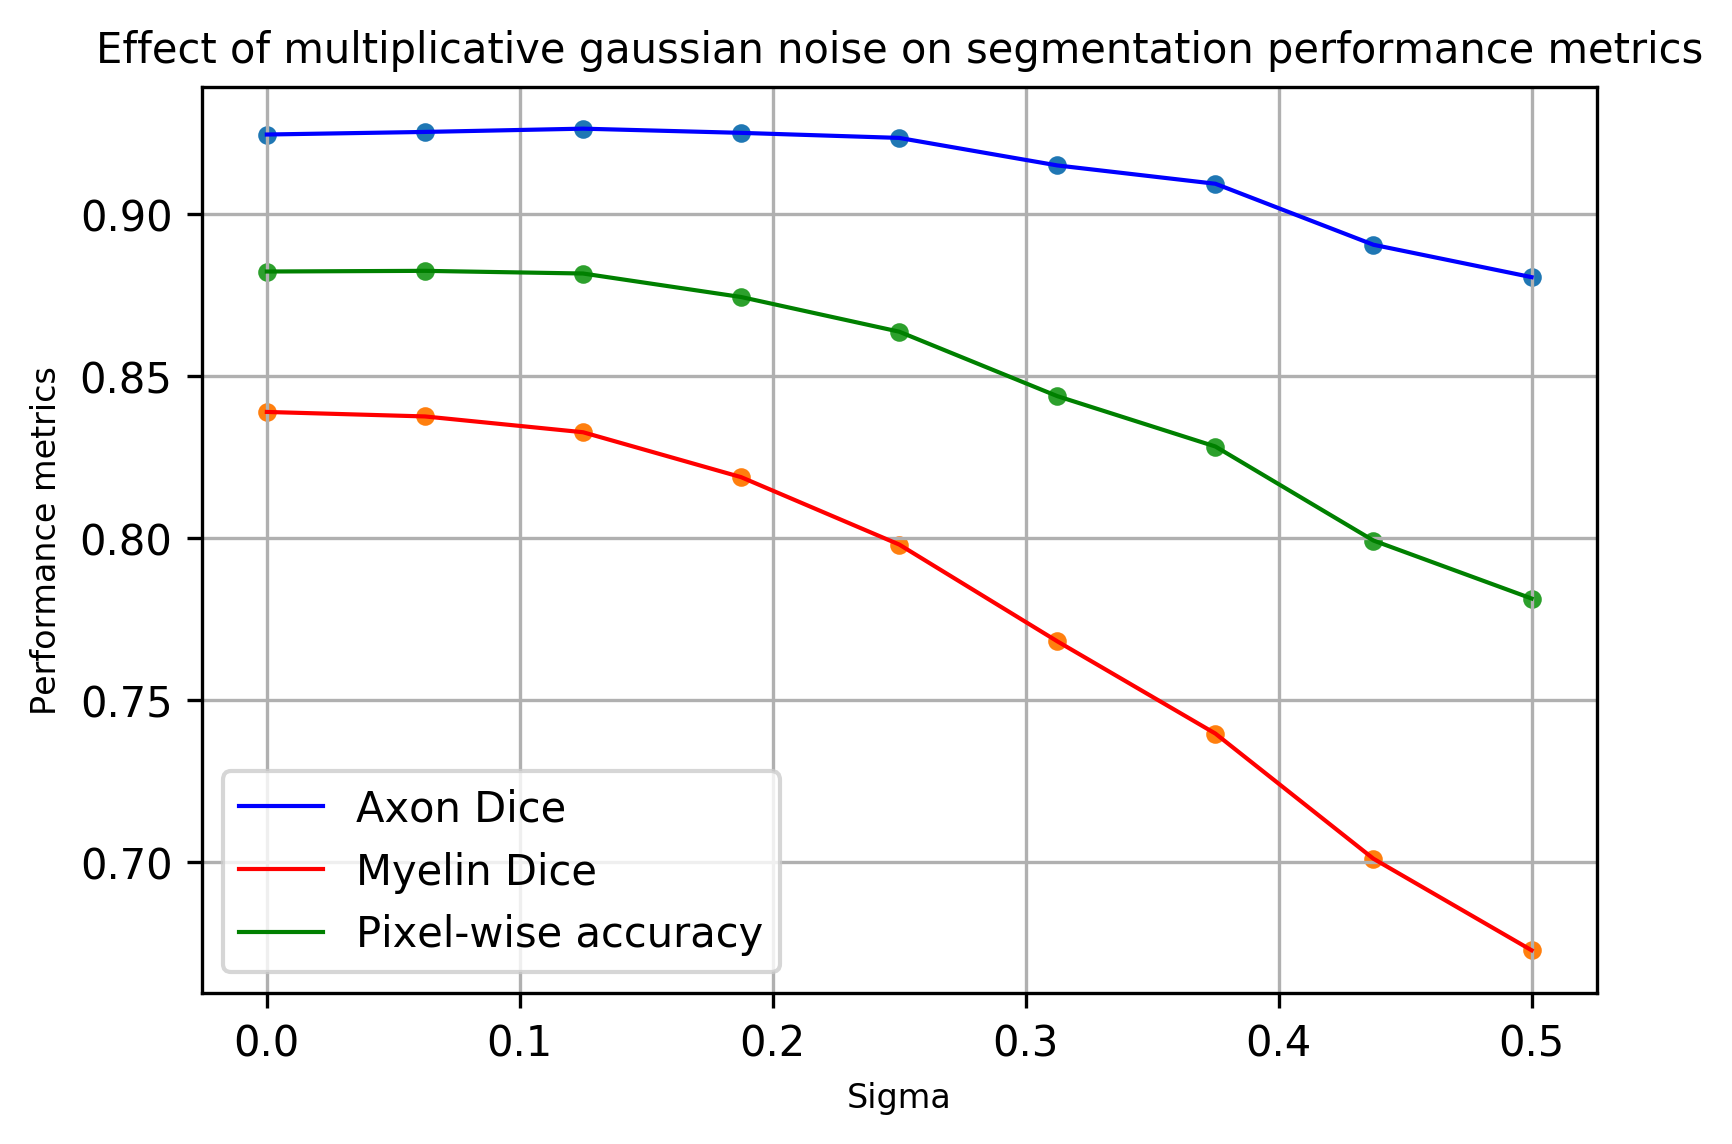

In [62]:
plt.figure(dpi=300)
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.hold(True) 
plt.plot(values, pw_accuracy_array, 'g', lw=1)
plt.scatter(values, pw_accuracy_array, s=12)

plt.xlabel('Sigma',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of multiplicative gaussian noise on segmentation performance metrics',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice','Pixel-wise accuracy'])
#plt.xlim(0, 0.3)
plt.grid(True)

Text(0.5,0.98,u'Sigma of multiplicative gaussian noise')

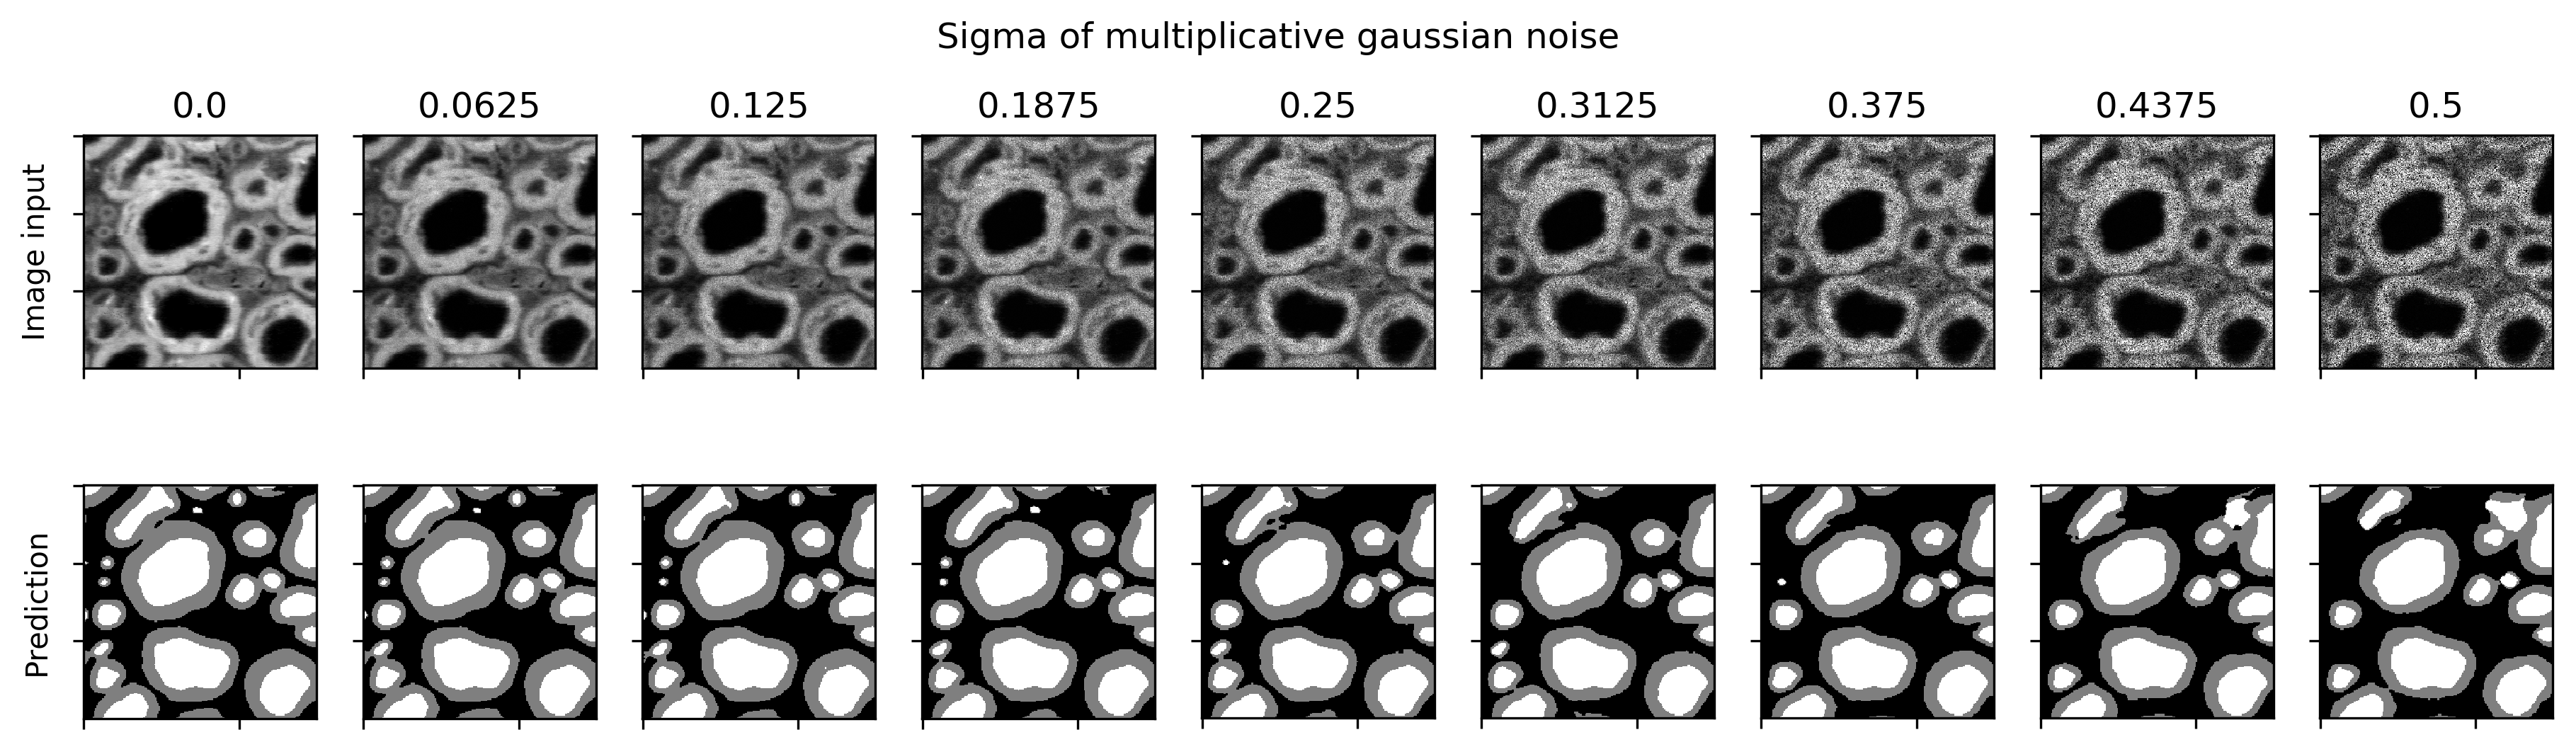

In [63]:
fig = plt.figure(figsize=(15,4),dpi=300)
items = np.arange(0,values.size)

for pos in items:

    plt.subplot(2,items.size,pos+1)
    plt.imshow(img_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.title('%s'%((values[pos])))
    
    if pos==0:
        plt.ylabel('Image input',fontsize=10)

    plt.subplot(2,items.size,(pos+1)+items.size)
    plt.imshow(pred_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([]) 
    
    if pos==0:
        plt.ylabel('Prediction',fontsize=10)
    
plt.suptitle("Sigma of multiplicative gaussian noise", fontsize=12)  


#### 4) Batch for simulation of contrast or brightness change:

- For all noise values, generates noisy image, creates sub-folder, saves noisy image, launches AxonDeepSeg segmentation on noisy image, computes and saves prediction accuracy.

In [59]:
values = np.linspace(0,0.9,9)
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
pw_accuracy_array = np.empty(0)
img_array = []
pred_array = []

for blending_values in values:
    
    # Generate and save noisy image
    img_noise = decrease_brightness(img,blending_values)
    file_name = 'image_' + str(int(blending_values*100)) + '.png'
    directory_name = 'image_illum_' + str(int(blending_values*100))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    imageio.imwrite(os.path.join(path_folder,directory_name,file_name),img_noise)
    img_array.append(img_noise[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy.png'),img_noise[100:400,100:400])
    
    # Segment noisy image with AxonDeepSeg
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_array.append(prediction[100:400,100:400])
    imageio.imwrite(os.path.join(path_folder,directory_name,'noisy_pred.png'),prediction[100:400,100:400])
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    pw_accuracy = classification_accuracy(prediction,mask)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    pw_accuracy_array = np.append(pw_accuracy_array, [pw_accuracy], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin, 'pixelwise_accuracy': pw_accuracy}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()

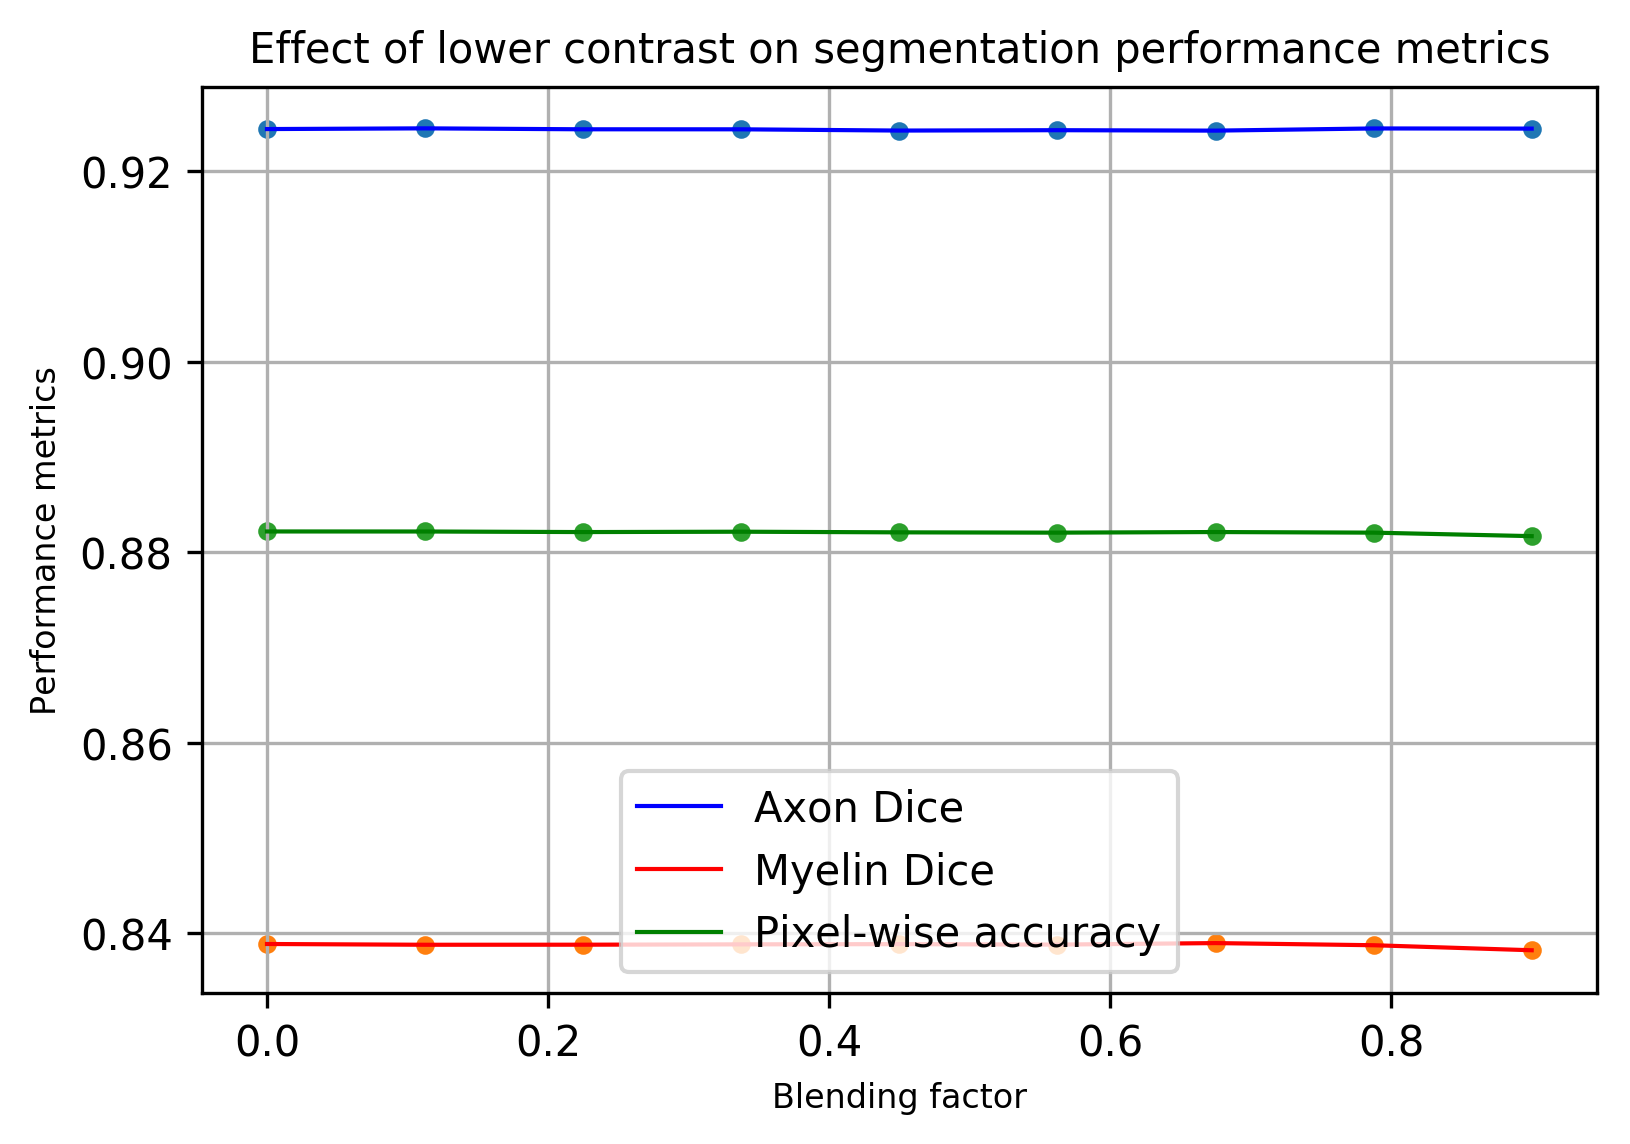

In [38]:
plt.figure(dpi=300)
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.hold(True) 
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.hold(True) 
plt.plot(values, pw_accuracy_array, 'g', lw=1)
plt.scatter(values, pw_accuracy_array, s=12)

plt.xlabel('Blending factor',fontsize=8)
plt.ylabel('Performance metrics',fontsize=8)
plt.title('Effect of lower contrast on segmentation performance metrics',fontsize=10)
plt.legend(['Axon Dice','Myelin Dice','Pixel-wise accuracy'])
#plt.xlim(0, 0.3)
plt.grid(True)

Text(0.5,0.98,u'Blending factor')

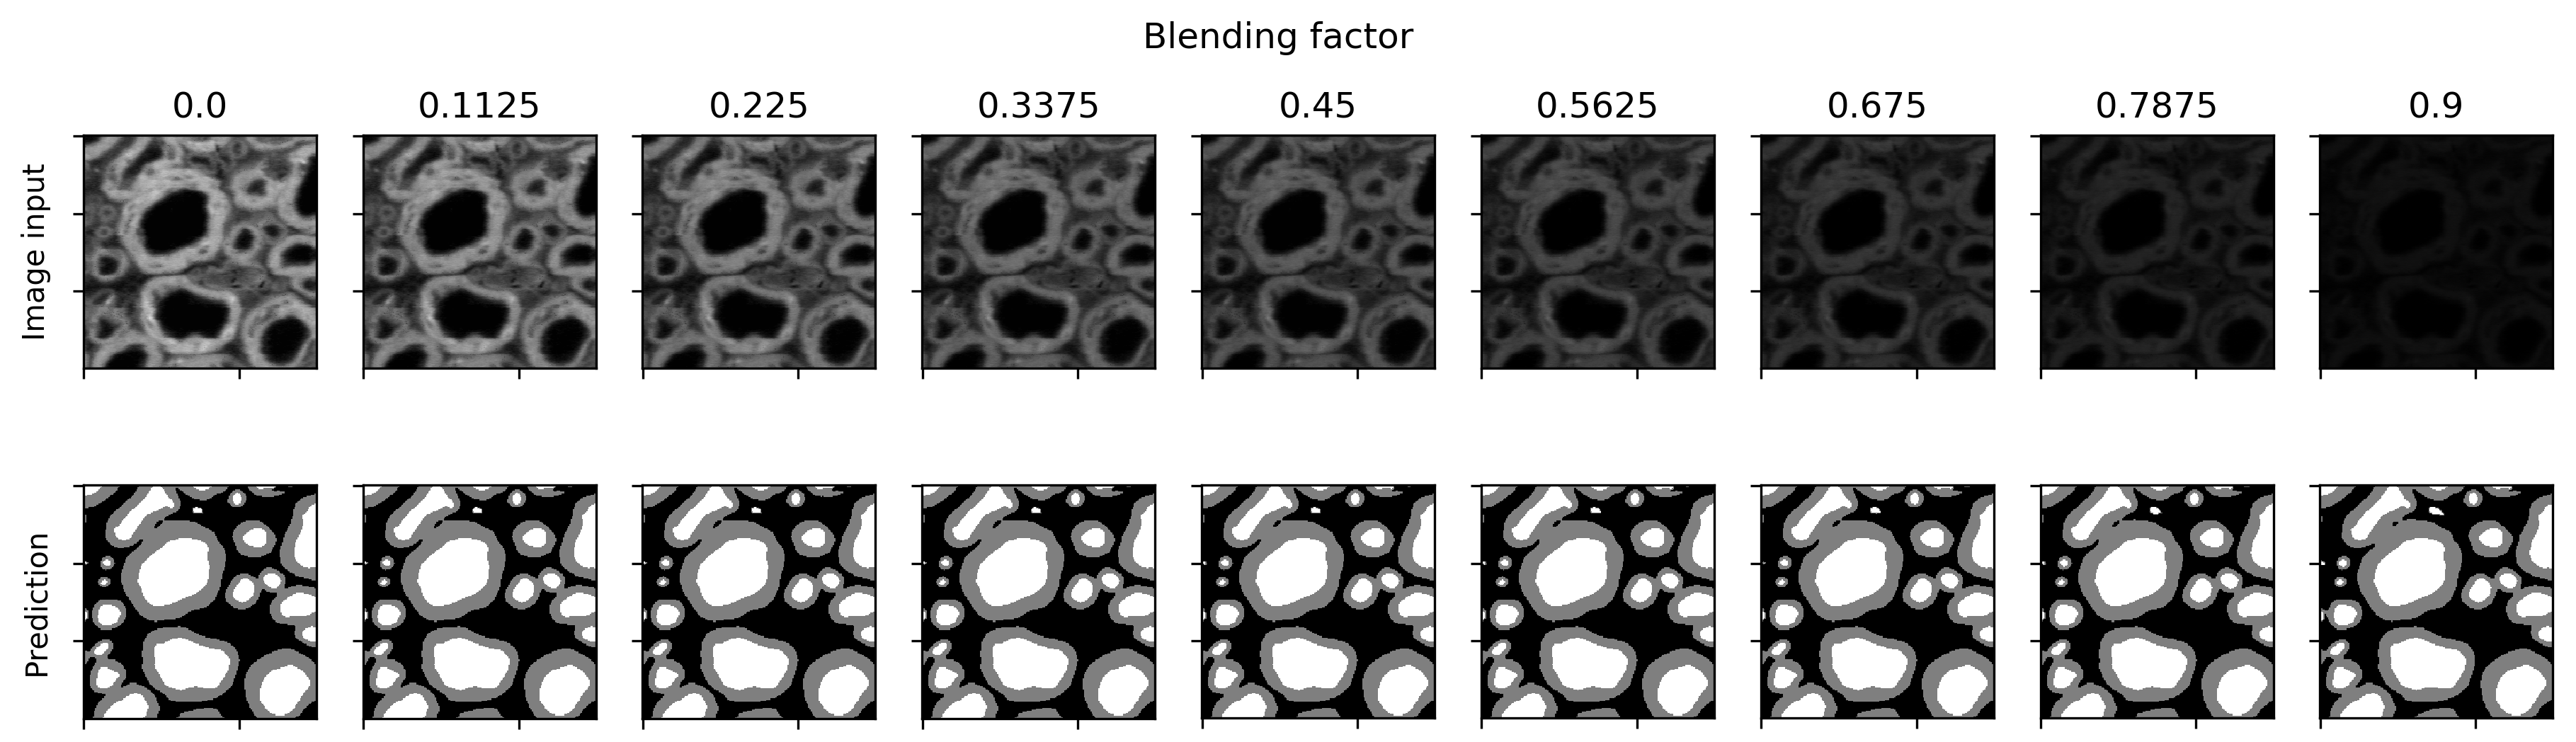

In [60]:
fig = plt.figure(figsize=(15,4),dpi=300)
items = np.arange(0,values.size)

for pos in items:

    plt.subplot(2,items.size,(pos+1))
    img_array[pos][0,0]=0
    img_array[pos][0,1]=255
    plt.imshow(img_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.title('%s'%((values[pos])))
    
    if pos==0:
        plt.ylabel('Image input',fontsize=10)

    plt.subplot(2,items.size,(pos+1)+items.size)
    plt.imshow(pred_array[pos], cmap='gray')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([]) 
    
    if pos==0:
        plt.ylabel('Prediction',fontsize=10)
    
plt.suptitle("Blending factor", fontsize=12)  

252.0


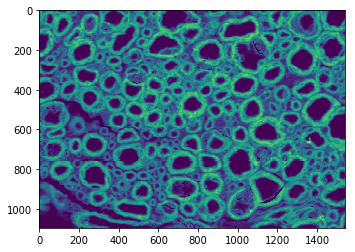

In [21]:
img_noise = gaussian(img, 0)
img_noise = img_noise*255
plt.imshow(img_noise)
print np.max(img_noise)